# Table of Contents
```
1. Business Understanding
   1.1. Problem Description
2. Data Understanding
   2.1. Import Libraries, Modules, Functions, Objects, etc.
   2.2. User Defined Functions (UDFs)
   2.3. Data Loading
   2.4. Exploratory Data Analysis (EDA)
        2.4.1. Text EDA: Understand the raw data with Descriptive Statistics
        2.4.2. Visual EDA: Understand the data with Visualizations
               2.4.2.1. Draw Univariate plots to better understand each attribute
               2.4.2.2. Draw Multivariate plots to better understand the relationship between attributes
3. Research
   3.1. List of selected algorithms to build models
   3.2. List of model evaluation metrics
4. Data Preprocessing
   4.1. Data Cleaning
        4.1.1. Basic data cleaning
        4.1.2. Outliers detection and removal
   4.2. Feature Selection
   4.3. Feature Engineering
        4.3.1. Create a new attribute sqft_price to further identify outliers
        4.3.2. Correlation map
        4.3.3. Outliers removal using SD
        4.3.4. Plot the cleaned data for sanity check
        4.3.5. Feature observation
        4.3.6. Dummy encoding on categorical values location
        4.3.7. Remove the attributes that are not required anymore
        4.3.8. Keep only one dataframe (df_cleaned) and delete the rest and release memory for ML processing
        4.3.9. Reorder columns in df_cleaned
   4.4. Dimensionality Reduction
   4.5. Split datasets for train-test
        4.5.1. Create Independent(X) and Dependent(y) variables
        4.5.2. Split the dataset into train and test
   4.6. Data Transforms
5. Model Development
   5.1. Model definitions
6. Model Training
7. Model Refinement
   7.1. Hyperparameters Optimization with Grid Search
8. Model Evaluation
9. Final Model Selection
10. Model Validation
11. Model Deployment
```

# 1. Business Understanding

## 1.1. Problem Description

**`Problem statement`**:

`In business terms`: 

* Predict the most accurate housing price in Bengaluru, India, based on the dataset given *`Bengaluru_House_data.csv`*.

`In analytical terms`: 
* Build several predictive models to predict the housing price and choose the best one based on the evaluation metrics.
* Use this project to demostrate most commonly used regression algorithms.

**`Type of the problem`**: Supervised Learning - Regression

**`Data source(s)`**: [Kaggle](https://www.kaggle.com/amitabhajoy/bengaluru-house-price-data)
    
**`Author(s)`**: Balasubramanian Chandran

# 2. Data Understanding

## 2.1. Import Libraries, Modules, Functions, Objects, etc.

In [1]:
# Import necessary libraries for this project
import sys         as sys
import numpy       as np
import pandas      as pd
import sklearn     as sk
import seaborn     as sns
import matplotlib  as mpl
import pickle      as pickle
import warnings

# Import necessary Modules, Functions and Objects from the Libraries
from pandas                        import read_csv, read_excel
from datetime                      import datetime
from sklearn.metrics               import r2_score as r2s, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection       import train_test_split
from sklearn.model_selection       import GridSearchCV, RepeatedKFold
from matplotlib                    import pyplot as plt
from sklearn.linear_model          import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors             import KNeighborsRegressor
from sklearn.tree                  import DecisionTreeRegressor

# Check the versions of the imported libraries
print("Versions of imported libraries:")
print("Python:     {}".format(sys.version))
print("Numpy:      {}".format(np.__version__))
print("Pandas:     {}".format(pd.__version__))
print("skLearn:    {}".format(sk.__version__))
print("Seaborn:    {}".format(sns.__version__))
print("Matplotlib: {}".format(mpl.__version__))

# Optional settings
mpl.style.use('ggplot')
sns.set(style='whitegrid')
pd.set_option('display.max_columns', None, 'precision', 3)
warnings.filterwarnings('ignore')

print(__doc__)

Versions of imported libraries:
Python:     3.8.8 (default, Feb 24 2021, 15:54:32) [MSC v.1928 64 bit (AMD64)]
Numpy:      1.19.5
Pandas:     1.3.2
skLearn:    0.24.2
Seaborn:    0.11.2
Matplotlib: 3.4.2
Automatically created module for IPython interactive environment


## 2.2. User Defined Functions (UDFs)

In [2]:
def is_num(x):
    try:
        float(x)
    except:
        return False
    return True

def convert_range_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0]) + float(tokens[1])) / 2
    try:
        return float(x)
    except:
        return None

def plot_boxnwhiskers(df, features, rows, cols):
    fig = plt.figure(figsize=(9,7))
    sns.set_style('darkgrid')
    k=0
    for i, feature in enumerate(features):
        ax = fig.add_subplot(rows,cols,i+1)
        sns.boxplot(y=df.columns[k], data=df, orient='v', palette='Greens')
        k = k+1
        fig.tight_layout()  
    plt.show()
    
def plot_correlationmap(df):
    corr = df.corr()
    plt.figure(figsize = (7,5))
    sns.heatmap(corr, mask=corr<0.4, annot=True, annot_kws={'size': 10}, vmin=0.5, vmax=1, cmap='BuPu', square=True)

def plot_scatter(df, location):
    plt.figure(figsize=(10,8))
    bhk1_df = df[(df.location.str.lower() == location.lower()) & (df.bhk == 1)]
    bhk2_df = df[(df.location.str.lower() == location.lower()) & (df.bhk == 2)]
    bhk3_df = df[(df.location.str.lower() == location.lower()) & (df.bhk == 3)]
    bhk5_df = df[(df.location.str.lower() == location.lower()) & (df.bhk == 5)]
    bhk8_df = df[(df.location.str.lower() == location.lower()) & (df.bhk == 8)]
    plt.scatter(x=bhk1_df.total_sqft, y=bhk1_df.price, c='red', label='1 BHK', s=10)
    plt.scatter(x=bhk2_df.total_sqft, y=bhk2_df.price, c='blue', label='2 BHK', s=10)
    plt.scatter(x=bhk3_df.total_sqft, y=bhk3_df.price, c='green', label='3 BHK', s=10)
    plt.scatter(x=bhk5_df.total_sqft, y=bhk5_df.price, c='orange', label='5 BHK', s=10)
    plt.scatter(x=bhk8_df.total_sqft, y=bhk8_df.price, c='yellow', label='8 BHK', s=10)
    plt.title(location.title())
    plt.xlabel('Total Square Feet')
    plt.ylabel('Price (Rs. in Lakhs)')
    plt.legend()

def plot_features_against_price(df, features, price):
    plt.figure(figsize=(14,4))
    y = df[price]
    for i, col in enumerate(df[features]):
        plt.subplot(1, len(features), i+1)
        x = df[col]
        plt.plot(x, y, '.')
        plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))   # Regression line
        plt.xlabel(col)
        plt.ylabel('Price')

def df_swap_columns(df, col1, col2):
    i = list(df.columns)
    a, b = i.index(col1), i.index(col2)
    i[b], i[a] = i[a], i[b]
    df = df[i]
    return df

def plot_performance_metrics(scores_list, scores_names, colors, modelnames):
    fig, axes = plt.subplots(1, len(scores_names), figsize=(13, 5))
    for i in range(len(scores_names)):
        axes[i].bar(modelnames, scores_list[i], color=colors[i])
        axes[i].set_title(scores_names[i], fontsize=15, alpha=0.6, pad=20)
    j = 0
    for scores in scores_list:
        xpos = 0
        for i in scores:
            text = str(i)[:5]
#            if scores == scores_list[0]:
#                text = str(i*100)[:5]
#            else:
#                text = str(i)[:5]
            axes[j].text(x=xpos, y=i, s=text, ha='center', va='bottom')
            for spine in axes[j].spines:
                axes[j].spines[spine].set_visible(False)
                axes[j].spines['left'].set_visible(True)
                axes[j].spines['left'].set_alpha(0.4)
                axes[j].spines['bottom'].set_visible(True)
                axes[j].spines['bottom'].set_alpha(0.4)
            xpos += 1
        j += 1
    plt.show()

def find_optimal_hyperparameters(model, space, X_in, y_in):
    rkf = RepeatedKFold(n_splits=10, n_repeats=2, random_state=10)                                # Define evaluation
    gsr2s = GridSearchCV(model, space, cv=rkf, n_jobs=-1, scoring='r2')                           # Define search
    gsmae = GridSearchCV(model, space, cv=rkf, n_jobs=-1, scoring='neg_mean_absolute_error')      # Define search
    result_r2s  = gsr2s.fit(X_in, y_in)                                                           # Execute search
    result_mae  = gsmae.fit(X_in, y_in)                                                           # Execute search
    return result_r2s, result_mae    

def predict_house_price(model, location, sqft, bhk, bath):
    location = location.strip().casefold()
    locindex = np.where(X.columns == location)[0][0]
    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bhk
    x[2] = bath
    if locindex >= 0:
        x[locindex] = 1
    return model.predict([x])[0]

## 2.3. Data Loading

In [3]:
## Load the necessary data files for this project ##
filename = 'data/Bengaluru_House_Data.csv'
house_df = read_csv(filename)

## 2.4. Exploratory Data Analysis (EDA)

### 2.4.1. `Text EDA`: Understand the raw data with Descriptive Statistics

#### Dimensions of the `house` dataset:

In [4]:
house_df.shape

(13320, 9)

#### Initial look at the raw data - First & Last 10 rows:

In [5]:
house_df.head(10).style.background_gradient(cmap='Blues', axis='rows').highlight_null(null_color='brown')

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.000,1.000,39.070
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.000,3.000,120.000
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,nan,1440,2.000,3.000,62.000
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.000,1.000,95.000
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,nan,1200,2.000,1.000,51.000
5,Super built-up Area,Ready To Move,Whitefield,2 BHK,DuenaTa,1170,2.000,1.000,38.000
6,Super built-up Area,18-May,Old Airport Road,4 BHK,Jaades,2732,4.000,nan,204.000
7,Super built-up Area,Ready To Move,Rajaji Nagar,4 BHK,Brway G,3300,4.000,nan,600.000
8,Super built-up Area,Ready To Move,Marathahalli,3 BHK,nan,1310,3.000,1.000,63.250
9,Plot Area,Ready To Move,Gandhi Bazar,6 Bedroom,nan,1020,6.000,nan,370.000


In [6]:
house_df.tail(10).style.background_gradient(cmap='Blues', axis='rows').highlight_null(null_color='brown')

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
13310,Super built-up Area,Ready To Move,Rachenahalli,2 BHK,nan,1050,2.000,2.000,52.710
13311,Plot Area,Ready To Move,Ramamurthy Nagar,7 Bedroom,nan,1500,9.000,2.000,250.000
13312,Super built-up Area,Ready To Move,Bellandur,2 BHK,nan,1262,2.000,2.000,47.000
13313,Super built-up Area,Ready To Move,Uttarahalli,3 BHK,Aklia R,1345,2.000,1.000,57.000
13314,Super built-up Area,Ready To Move,Green Glen Layout,3 BHK,SoosePr,1715,3.000,3.000,112.000
13315,Built-up Area,Ready To Move,Whitefield,5 Bedroom,ArsiaEx,3453,4.000,0.000,231.000
13316,Super built-up Area,Ready To Move,Richards Town,4 BHK,nan,3600,5.000,nan,400.000
13317,Built-up Area,Ready To Move,Raja Rajeshwari Nagar,2 BHK,Mahla T,1141,2.000,1.000,60.000
13318,Super built-up Area,18-Jun,Padmanabhanagar,4 BHK,SollyCl,4689,4.000,1.000,488.000
13319,Super built-up Area,Ready To Move,Doddathoguru,1 BHK,nan,550,1.000,1.000,17.000


#### Basic information of the dataset:

In [7]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


#### Statistical summary of the dataset:

In [8]:
house_df.describe()

,bath,balcony,price
count,13247.000,12711.000,13320.000
mean,2.693,1.584,112.566
std,1.341,0.817,148.972
min,1.000,0.000,8.000
25%,2.000,1.000,50.000
50%,2.000,2.000,72.000
75%,3.000,2.000,120.000
max,40.000,3.000,3600.000


#### Explore NA/NULL values in the dataset:

In [9]:
null_values     = pd.DataFrame(data=house_df.isnull().sum(), columns=['NULL count'])
null_values_per = pd.DataFrame(round(house_df.isnull().sum() / len(house_df) * 100, 2), columns=['NULL Percentage'])
null_values_df  = pd.concat([null_values, null_values_per], axis=1)
null_values_df

,NULL count,NULL Percentage
area_type,0,0.00
availability,0,0.00
location,1,0.01
size,16,0.12
society,5502,41.31
total_sqft,0,0.00
bath,73,0.55
balcony,609,4.57
price,0,0.00


#### Explore duplicates in the dataset:

In [10]:
dup_df = house_df.drop_duplicates()
print('Number of duplicates found:', (len(house_df) - len(dup_df)))

Number of duplicates found: 529


#### Explore why the datatypes of attributes `size` & `total_sqft` are `objects` instead of `float`:

In [11]:
size_nans       = house_df['size'].isnull().sum()
total_sqft_nans = len(house_df[~house_df['total_sqft'].apply(is_num)])
print(f'{"Number of Nulls in size attribute:":<39}{size_nans:>5}')
print(f'{"Number of NaNs in total_sqft attribute:":<39}{total_sqft_nans:>5}')

Number of Nulls in size attribute:        16
Number of NaNs in total_sqft attribute:  247


#### Explore the `area_type` attribute:

In [12]:
house_df['area_type'].value_counts()     # Alternate methods 'Counter(house_df.area_type)' or 'house_df.groupby('area_type').size()'

Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: area_type, dtype: int64

#### Explore the `Location` attribute:

In [13]:
house_df['location'].value_counts()

Whitefield                        540
Sarjapur  Road                    399
Electronic City                   302
Kanakpura Road                    273
Thanisandra                       234
                                 ... 
Bapuji Layout                       1
1st Stage Radha Krishna Layout      1
BEML Layout 5th stage               1
singapura paradise                  1
Abshot Layout                       1
Name: location, Length: 1305, dtype: int64

### 2.4.2. `Visual EDA`: Understand the data with Visualizations

#### 2.4.2.1. Draw Univariate plots to better understand each attribute

This should be done after Data Preprocessing as some attributes contain text values.

#### 2.4.2.2. Draw Multivariate plots to better understand the relationship between attributes

This should be done after Data Preprocessing as some attributes contain text values.

# 3. Research

## 3.1. List of selected algorithms to build models

The following 8 regression algorithms covering a variety of regression strategies, techniques, cross-validation capabilities and regularization features, have been selected for this project. All 8 models will be developed with default parameters and trained. Only a few best will be selected for algorithm tuning based on their performances (evaluation metrics). Then, each of those models will be individually tuned to minimize error. The final model will be selected based on their evaluation metrics on training and test datasets.

#### Regression algorithms:
```
 1) Oridinary Least Squares (OLS)    LinearRegression()             - Linear
 2) Lasso (Lasso)                    Lasso()                        - Linear
 3) Ridge (Ridge)                    Ridge()                        - Linear
 4) ElasticNet (ENet)                ElasticNet()                   - Linear
 5) K-Nearest Neighbors (KNN)        KNeighborsRegressor()          - Non-linear
 6) Decision Tree (DT)               DecisionTreeRegressor()        - Non-linear
```

## 3.2. List of model evaluation metrics

#### Regression model evaluation metrics:
The following metrics have been selected as the `evaluation metrics` for training, refining and evaluating the models.
```
1) R^2 Score (Coefficient of Determination)
2) MAE (Mean Absolute Error)
3) MSE (Mean Squared Error)
4) Algorithm run-time
```

Build the above mentioned models, with default parameters, and select the best one based on their `train` & `test` scores.

#### Additional Note:
* Remove attributes `area_type`, `availability` & `society` as they are non-numeric and not required for regression models.
* Remove attribute `balcony` as there are significant missing values which may skew the results.
* Rename `size` to `bhk`.
* Convert non-numeric data as numeric in the `bhk`, `total_sqft` attributes.
* Convert attributes to 'int' datatype that have numbers as texts, e.g., bhk, total_sqft.
* Handling missing values - either remove the samples or fill them as appropriate (location, bhk, bath) 
* Capture the algorithm's execution time for training and test.
* The goal is to achieve a model with `low Bias` and `low Variance`. Select the final model based on the Bias-Variance trade-off.

# 4. Data Preprocessing

## 4.1. Data Cleaning

### 4.1.1. Basic data cleaning

#### Remove the duplicate features/columns

*No duplicate features/columns in the dataset.*

#### Remove unwanted features/columns `area_type`, `availability`, `society`, `balcony`

In [14]:
df1 = house_df.copy()
df1.drop(columns=['area_type', 'availability', 'society', 'balcony'], inplace=True)
df1.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


#### Rename feature `size` to `bhk`

In [15]:
df1.rename(columns={'size':'bhk'}, inplace=True)
df1.head()

,location,bhk,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


#### Remove embedded characters that may cause data misalignment

In [16]:
df2 = pd.DataFrame(df1['location'])
df1.drop(columns=['location'], inplace=True)
df2['location'] = df2['location'].str.strip()      # Trim leading & trailing whitespaces
df2['location'] = df2['location'].str.casefold()   # Convert to lower cases
df2 = pd.concat([df2, df1], axis='columns')
df2.shape

(13320, 5)

#### Remove the duplicate samples/rows

In [17]:
df3 = df2.drop_duplicates()
no_of_duplicates = len(df2) - len(df3)
print('Number of deplicate samples/rows removed: ', no_of_duplicates)
df3.shape

Number of deplicate samples/rows removed:  883


(12437, 5)

*NOTE: Removal of 4 features has lead to additional 354 (883 - 529) duplicate rows, hence the number of duplicate rows jumped from 529 to 883.*

#### Handling inconsistent data - Convert range values in `total_sqft` to single numbers

In [18]:
df3.total_sqft = df3.total_sqft.apply(convert_range_to_num)

#### Explore NA/NULL values after the removal of unwanted columns and duplicate rows

In [19]:
null_values     = pd.DataFrame(data=df3.isnull().sum(), columns=['NULL count'])
null_values_per = pd.DataFrame(round(df3.isnull().sum() / len(df3) * 100, 2), columns=['NULL Percentage'])
null_values_df  = pd.concat([null_values, null_values_per], axis=1)
null_values_df

,NULL count,NULL Percentage
location,1,0.01
bhk,16,0.13
total_sqft,46,0.37
bath,72,0.58
price,0,0.00


#### Handling missing/Null values

In [20]:
# Remove Null from 'location' attribute
loc_nulls = df3['location'].isnull().sum()
df3       = df3[df3['location'].notnull()]

# Remove NaN from 'bhk' and Convert 'bhk' to numbers
tmp        = len(df3)
df3        = df3[df3['bhk'].notnull()]
df3['bhk'] = df3['bhk'].str.split().str[0]
df3['bhk'] = df3['bhk'].astype('int')
bhk_nulls  = tmp - len(df3)
df3.reset_index(drop=True, inplace=True)

# Remove NaN from 'bath' attribute
tmp        = len(df3)
df3        = df3[df3['bath'].notnull()]
bath_nulls = tmp - len(df3)

samples_after_null_removal = len(df3)

print(f'{"Number of samples removed for Nulls in location attribute:":<70}{loc_nulls:>5}')
print(f'{"Number of samples removed for Nulls in bhk attribute:":<70}{bhk_nulls:>5}')
print(f'{"Number of samples removed for Nulls in bath attribute:":<70}{bath_nulls:>5}')
print(f'{"Number of samples in the dataset after handling missing/null values:":<70}{samples_after_null_removal:>5}')

df3.reset_index(drop=True, inplace=True)
df3.head(2)

Number of samples removed for Nulls in location attribute:                1
Number of samples removed for Nulls in bhk attribute:                    16
Number of samples removed for Nulls in bath attribute:                   56
Number of samples in the dataset after handling missing/null values:  12364


,location,bhk,total_sqft,bath,price
0,electronic city phase ii,2,1056.0,2.0,39.07
1,chikka tirupathi,4,2600.0,5.0,120.00


#### Handling errors/noisy data

The ratio between **`total_sqft`** and **`bhk`** should be at least 200 sqft, otherwise it should be a data entry error which can be removed.

In [21]:
df3 = df3[~(df3.total_sqft / df3.bhk < 200)]
print(f'{"Number of samples removed for errors:":<68}{(samples_after_null_removal - len(df3)):>5}')

samples_after_error_removal = len(df3)
print(f'{"Number of samples in the dataset after handling errors/noisy data:":<68}{samples_after_error_removal:>5}')

Number of samples removed for errors:                                 338
Number of samples in the dataset after handling errors/noisy data:  12026


### 4.1.2. Outliers detection and removal

#### Boxplots *before* outliers removal:

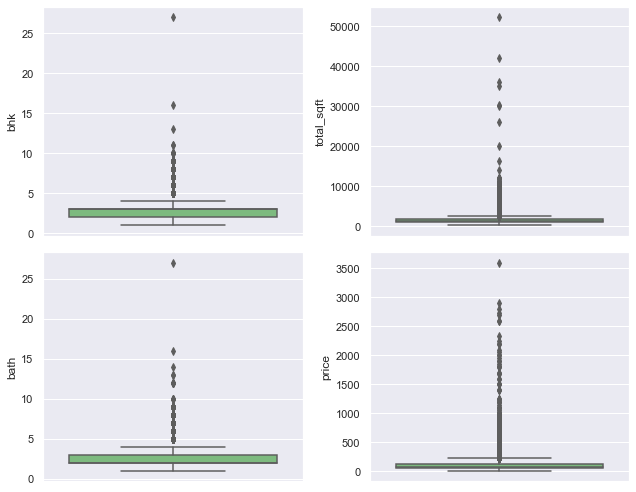

In [22]:
plot_boxnwhiskers(df3.iloc[:, 1:], df3.columns[1:5], 2, 2)

#### Remove outliers from `bhk` & `bath` columns:

In [23]:
df4 = df3[df3['bhk'] < 10]
df5 = df4[df3['bath'] < 10]

print(f'{"Number of samples removed for Outliers in bhk:":<60}{(len(df3) - len(df4)):>5}')
print(f'{"Number of samples removed for Outliers in bath:":<60}{(len(df4) - len(df5)):>5}')
print(f'{"Number of samples in the dataset after removing Outliers:":<60}{len(df5):>5}')

Number of samples removed for Outliers in bhk:                 12
Number of samples removed for Outliers in bath:                 5
Number of samples in the dataset after removing Outliers:   12009


#### Boxplots *after* outliers removal:

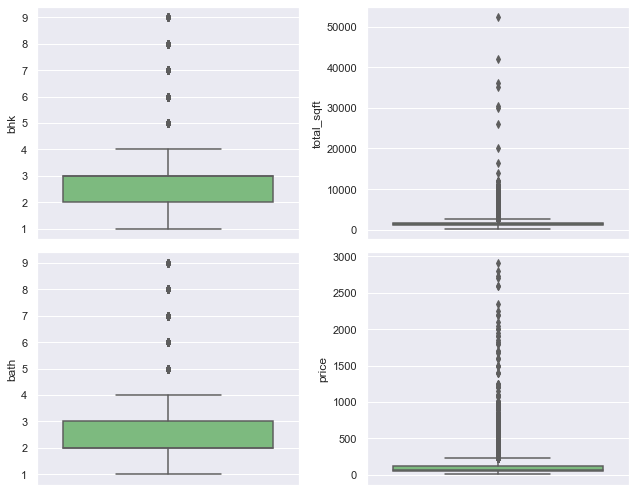

In [24]:
plot_boxnwhiskers(df5.iloc[:, 1:], df5.columns[1:5], 2, 2)

## 4.2. Feature Selection

*Unwanted features have already been removed in section 4.1.1.*

## 4.3. Feature Engineering

### 4.3.1. Create a new attribute `sqft_price` to further identify outliers

In [25]:
df5['sqft_price'] = round(df5['price'] / df5['total_sqft'] * 100000, 2)

df5.reset_index(drop=True, inplace=True)
df5

,location,bhk,total_sqft,bath,price,sqft_price
0,electronic city phase ii,2,1056.0,2.0,39.07,3699.81
1,chikka tirupathi,4,2600.0,5.0,120.00,4615.38
2,uttarahalli,3,1440.0,2.0,62.00,4305.56
3,lingadheeranahalli,3,1521.0,3.0,95.00,6245.89
4,kothanur,2,1200.0,2.0,51.00,4250.00
...,...,...,...,...,...,...
12004,green glen layout,3,1715.0,3.0,112.00,6530.61
12005,whitefield,5,3453.0,4.0,231.00,6689.83
12006,richards town,4,3600.0,5.0,400.00,11111.11
12007,raja rajeshwari nagar,2,1141.0,2.0,60.00,5258.55


### 4.3.2. Correlation map

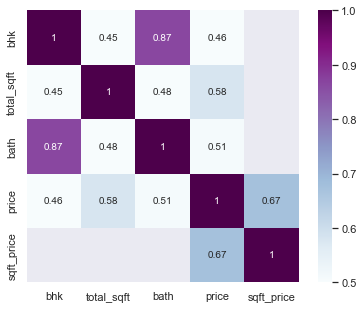

In [26]:
plot_correlationmap(df5)

In [27]:
print('Statistical summary of \'sqft_price\':')
df5['sqft_price'].describe()

Statistical summary of 'sqft_price':


count     11963.000
mean       6585.123
std        4414.188
min         267.830
25%        4285.710
50%        5425.710
75%        7206.755
max      176470.590
Name: sqft_price, dtype: float64

### 4.3.3. Outliers removal using SD

In [28]:
# Take values with the 1st SD, by location
df6 = pd.DataFrame()
for i, df in df5.groupby('location'):
    mean      = np.mean(df.sqft_price)
    std       = np.std(df.sqft_price)
    temp_df   = df[(df.sqft_price >= (mean - std)) & (df.sqft_price <= (mean + std))]
    df6 = pd.concat([df6, temp_df], ignore_index=True)

print(f'{"Number of samples removed for Outliers for SD:":<68}{(len(df5) - len(df6)):>5}')
print(f'{"Number of samples in the dataset after removing further Outliers:":<68}{len(df6):>5}')

df6.reset_index(drop=True, inplace=True)
df6.shape

Number of samples removed for Outliers for SD:                       2540
Number of samples in the dataset after removing further Outliers:    9469


(9469, 6)

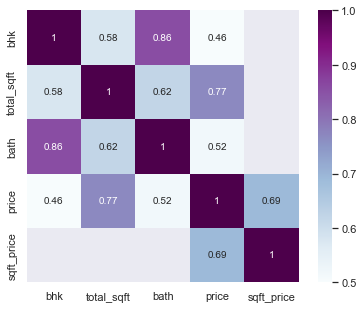

In [29]:
plot_correlationmap(df6)

*If the number of samples for any given location is less than 5, it may skew the distribution without adding any value to the model. Hence they should be removed.*

In [30]:
df7           = df6.copy()
df7.location  = df7.location.str.strip()
loc_count     = df7['location'].value_counts()
loc_count_lt5 = loc_count[loc_count < 5]
df7.location  = df7.location.apply(lambda x: 'other' if x in loc_count_lt5 else x)
df7           = df7[df7.location != 'other']
 
print(f'{"Number of samples removed for location less than 5:":<68}{(len(df6) - len(df7)):>5}')
print(f'{"Number of samples in the dataset after removing further Outliers:":<68}{len(df7):>5}')

df7.reset_index(drop=True, inplace=True)
df7.shape

Number of samples removed for location less than 5:                  1528
Number of samples in the dataset after removing further Outliers:    7941


(7941, 6)

### 4.3.4. Plot the cleaned data for sanity check

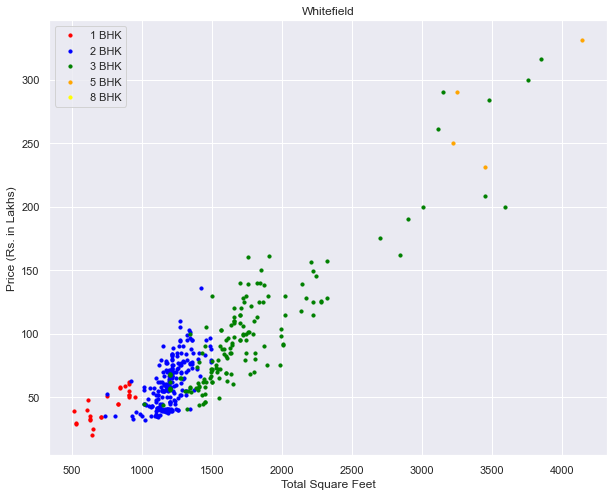

In [31]:
plot_scatter(df7, 'whitefield')

### 4.3.5. Feature observation

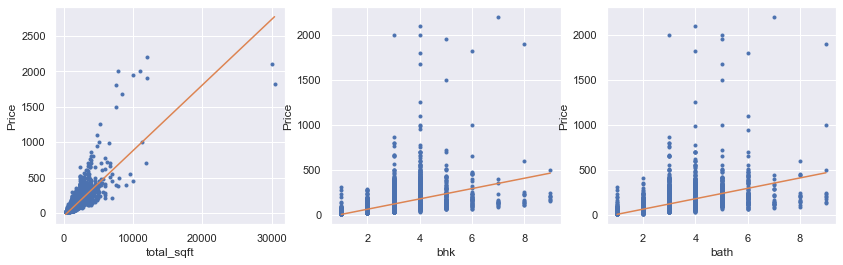

In [32]:
plot_features_against_price(df7, ['total_sqft', 'bhk', 'bath'], 'price')

### 4.3.6. Dummy encoding on categorical values location

In [33]:
dummies = pd.get_dummies(df7.location)
df8 = pd.concat([df7, dummies], axis='columns')
print('Shape of the dataset after adding dummies:', df8.shape)

Shape of the dataset after adding dummies: (7941, 314)


### 4.3.7. Remove the attributes that are not required anymore

In [34]:
df9 = df8.drop(columns=['location', 'sqft_price'], axis=1)
print('Shape of the dataset after removing the extra columns:', df9.shape)

Shape of the dataset after removing the extra columns: (7941, 312)


### 4.3.8. Keep only one dataframe (df_cleaned) and delete the rest and release memory for ML processing

In [35]:
df_cleaned = df9
del null_values, null_values_per, null_values_df, df1, df2, df3, df4, df5, df6, df7, df8, df9

### 4.3.9. Reorder columns in `df_cleaned`

In [36]:
df_cleaned = df_swap_columns(df_cleaned, 'bhk', 'total_sqft')  # Make sure the order is total_sqft, bhk, bath, price, .....
df_cleaned.head()

,total_sqft,bhk,bath,price,1st block jayanagar,1st block koramangala,1st phase jp nagar,2nd stage nagarbhavi,4th block koramangala,4th t block jayanagar,5th block hbr layout,5th phase jp nagar,6th phase jp nagar,7th phase jp nagar,8th block koramangala,8th phase jp nagar,9th phase jp nagar,abbaiah reddy layout,abbigere,aecs layout,akshaya nagar,akshaya vana,akshayanagara east,ambalipura,ambedkar nagar,amruthahalli,anand nagar,anandapura,ananth nagar,anekal,anjanapura,ardendale,arekere,attibele,austin town,b narayanapura,babusapalaya,balagere,banagiri nagar,banashankari,banashankari stage ii,banashankari stage iii,banashankari stage v,banashankari stage vi,banaswadi,banjara layout,bannerghatta,bannerghatta road,basapura,basavangudi,basaveshwara nagar,basaveshwara nagar yelahanka,battarahalli,begur,begur road,bellandur,beml layout,benson town,bharathi nagar,bhoganhalli,billekahalli,binny pete,bisuvanahalli,bommanahalli,bommasandra,bommasandra industrial area,bommenahalli,brookefield,btm 2nd stage,btm layout,budigere,byatarayanapura,cambridge layout,chamrajpet,chandapura,channasandra,channasandra layout,chennammana kere,chikka tirupathi,chikkabanavar,chikkalasandra,cholanayakanahalli,choodasandra,cooke town,cox town,cunningham road,cv raman nagar,dairy circle,dasanapura,dasarahalli,defence colony,devanahalli,devarabeesana halli,devarachikkanahalli,doctors layout,dodda nekkundi,dodda nekkundi extension,doddaballapur,doddakallasandra,doddakammanahalli,doddanekundi,doddathoguru,dodsworth layout,dollars colony,domlur,dommasandra,ejipura,electronic city,electronic city phase ii,electronics city phase 1,epip zone,frazer town,ganga nagar,garudachar palya,giri nagar,gm palaya,gollahalli,gollarapalya hosahalli,gopalkrishna nagar,gottigere,green glen layout,green view layout,gubbalala,gunjur,gunjur palya,haralur road,harlur,hbr layout,hebbal,hebbal kempapura,hegde nagar,hennur,hennur gardens,hennur road,hoodi,horamavu agara,horamavu banaswadi,hormavu,hosa road,hosakerehalli,hoskote,hosur road,hoysalanagar,hrbr layout,hsr layout,hulimavu,iblur village,indira nagar,isro layout,itpl,ittamadu,jakkur,jakkur plantation,jalahalli,jalahalli east,jigani,jp nagar,judicial layout,kadubeesanahalli,kadugodi,kaggadasapura,kaggalipura,kaikondrahalli,kalena agrahara,kalkere,kalyan nagar,kamakshipalya,kambipura,kammanahalli,kammasandra,kanakapura,kanakpura road,kannamangala,karuna nagar,kasavanhalli,kasturi nagar,kathriguppe,kattigenahalli,kaval byrasandra,kaverappa layout,kenchenahalli,kengeri,kengeri satellite town,kereguddadahalli,kodbisanhalli,kodichikkanahalli,kodigehaali,kodigehalli,kodihalli,kogilu,konanakunte,koramangala,kothannur,kothanur,kr puram,kudlu,kudlu gate,kumaraswami layout,kundalahalli,kundalahalli colony,laggere,lakshminarayana pura,lb shastri nagar,lingadheeranahalli,madiwala,magadi road,mahadevpura,mahalakshmi layout,mallasandra,malleshpalya,malleshwaram,manayata tech park,marathahalli,margondanahalli,marsur,mathikere,mico layout,ms pallya,munnekollal,murugeshpalya,mysore road,nagadevanahalli,naganathapura,nagappa reddy layout,nagarbhavi,nagasandra,nagavara,nagavarapalya,nallurhalli,neeladri nagar,nehru nagar,nelamangala,ngr layout,nri layout,"off sarjapur road,",old airport road,old madras road,ombr layout,outer ring road east,padmanabhanagar,pai layout,panathur,parappana agrahara,pattandur agrahara,peenya,poorna pragna layout,prithvi layout,r.t. nagar,rachenahalli,raja rajeshwari nagar,rajaji nagar,rajiv nagar,ramagondanahalli,ramakrishnappa layout,ramamurthy nagar,rayasandra,richmond town,sadashiva nagar,sahakara nagar,sanjay nagar,sarakki nagar,sarjapur,sarjapur road,"sarjapur road,",sarjapura - attibele road,sathya sai layout,sector 1 hsr layout,sector 2 hsr layout,sector 7 hsr layout,seegehalli,seetharampalya,shampura,shanti nagar,shikaripalya,shivaji nagar,singasandra,somasundara palya,sompura,sonnenahalli,subramanyapura,sultan palaya,talaghattapura,tc palaya,thanisandra,thigalarapalya,thirumenahalli,thubarahalli,tindlu,tumkur 

## 4.4. Dimensionality Reduction

Not done.

## 4.5. Split datasets for train-test

### 4.5.1. Create Independent(X) and Dependent(y) variables

In [37]:
X = df_cleaned.drop(['price'], axis=1)   # Independent variables
y = df_cleaned['price']                  # Dependent variable

### 4.5.2. Split the dataset into *`train`* and *`test`*

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print('X_train:', X_train.shape)
print('X_test :', X_test.shape)
print('y_train:', y_train.shape)
print('y_test :', y_test.shape)
print('X      :', X.shape)
print('y      :', y.shape)

X_train: (6352, 311)
X_test : (1589, 311)
y_train: (6352,)
y_test : (1589,)
X      : (7941, 311)
y      : (7941,)


## 4.6. Data Transforms

`NOTE`: In this project Feature scalling is of no use, because,
* the price prediction will be done using only 4 features, i.e., `location`, `sqft`, `bhk`, `bath`. Of which, *`location`* is a categorical variable.
* the preprocessed dataset has dummy encoders.

# 5. Model Development

## 5.1. Model definitions

In [39]:
models = []
models.append(('OLS', LinearRegression()))
models.append(('Lasso', Lasso()))
models.append(('Ridge', Ridge()))
models.append(('ENet', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('DT', DecisionTreeRegressor()))

# 6. Model Training

In [40]:
modelnames       = []
y_preds          = []
scores_r2s_trng  = []
scores_mae_trng  = []
scores_rmse_trng = []

print('Training the developed models in progress:')
start_time = datetime.now()

i = 0
for name, model in models:
    stime = datetime.now()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores_r2s_trng.append(r2s(y_pred, y_test))
    scores_mae_trng.append(mae(y_pred, y_test))
    scores_rmse_trng.append(mse(y_pred, y_test, squared=False))
    modelnames.append(name)
    y_preds.append(y_pred)
    i = i + 1
    etime = datetime.now()
    print('%15s  Training complete...  ' % name, (etime - stime))
    
end_time = datetime.now()
elapsed_time = end_time - start_time
print('\nTotal elapsed time: ', elapsed_time, '\n')

Training the developed models in progress:
            OLS  Training complete...   0:00:00.253949
          Lasso  Training complete...   0:00:00.084627
          Ridge  Training complete...   0:00:00.046871
           ENet  Training complete...   0:00:00.053375
            KNN  Training complete...   0:00:00.263069
             DT  Training complete...   0:00:00.238351

Total elapsed time:  0:00:00.940242 



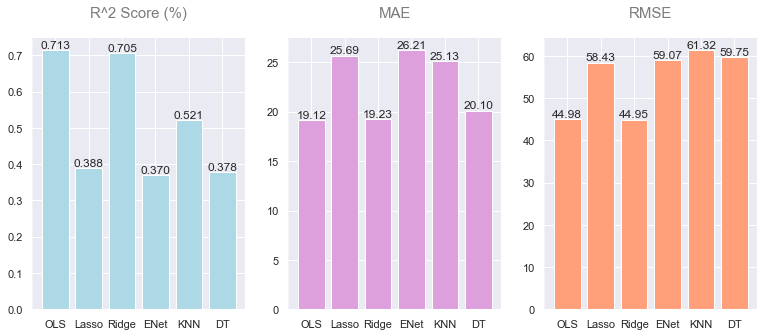

In [41]:
scores_list  = [scores_r2s_trng, scores_mae_trng, scores_rmse_trng]
scores_names = ['R^2 Score (%)', 'MAE', 'RMSE']
colors       = ['lightblue', 'plum', 'lightsalmon']

plot_performance_metrics(scores_list, scores_names, colors, modelnames)

Cut-off values considered for initial model selection are:

    R^2  Score cut-off:   > 0.70 (+ve measure, bigger  is better, Best score - 1, Poor score - 0)
    MAE  Score cut-off:   < 20.0 (-ve measure, smaller is better, Best score - 0, Poor score - 1)
    RMSE Score cut-off:   < 45.0 (-ve measure, smaller is better, Best score - 0, Poor score - 1)

Based on the training performance metrics, the following models are selected for model-tuning.

    1) Ordinary Least Squares (OLS)
    2) Ridge (Ridge)
    
*NOTE:* 
* Moving forward, let's use only R^2 Score and MAE as performance metrics.

# 7. Model Refinement

## 7.1. Hyperparameters Optimization with Grid Search

#### Ordinary Least Squares (OLS):

In [42]:
model                  = LinearRegression()                                            # Define model
space                  = dict()                                                        # Define search space
space['fit_intercept'] = [True, False]
space['normalize']     = [True, False]

result_r2s_ols, result_mae_ols = find_optimal_hyperparameters(model, space, X, y)

#### Ridge (Ridge):

In [43]:
model                  = Ridge()                                                     # Define model
space                  = dict()                                                      # Define search space
space['alpha']         = [0.01, 0.1, 1, 10]
space['fit_intercept'] = [True, False]
space['normalize']     = [True, False]

result_r2s_rdg, result_mae_rdg = find_optimal_hyperparameters(model, space, X, y)

In [44]:
scores_r2s_rfnd = [result_r2s_ols.best_score_, result_r2s_rdg.best_score_]
scores_mae_rfnd = [result_mae_ols.best_score_, result_mae_rdg.best_score_]

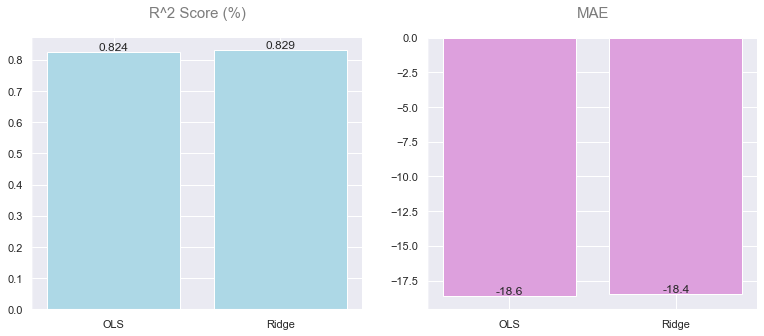

In [45]:
scores_list  = [scores_r2s_rfnd, scores_mae_rfnd]
scores_names = ['R^2 Score (%)', 'MAE']
colors       = ['lightblue', 'plum']
modelnms     = [modelnames[0], modelnames[2]]
plot_performance_metrics(scores_list, scores_names, colors, modelnms)

In [46]:
print('OLS   Best Hyperparameters: ', result_r2s_ols.best_params_)
print('Ridge Best Hyperparameters: ', result_r2s_rdg.best_params_)

OLS   Best Hyperparameters:  {'fit_intercept': False, 'normalize': True}
Ridge Best Hyperparameters:  {'alpha': 1, 'fit_intercept': False, 'normalize': True}


# 8. Model Evaluation

In [47]:
ols_fit_intercept = False
ols_normalize     = True
rdg_alpha         = 1
rdg_fit_intercept = False
rdg_normalize     = True

### ORDINARY LEAST SQARES ###
modelols = LinearRegression(fit_intercept=ols_fit_intercept, normalize=ols_normalize).fit(X_train, y_train)
predols  = modelols.predict(X_test)
result_r2s_ols = r2s(predols, y_test)
result_mae_ols = mae(predols, y_test)

### RIDGE ###
modelrdg = Ridge(alpha=rdg_alpha, fit_intercept=ols_fit_intercept, normalize=rdg_normalize).fit(X_train, y_train)
predrdg  = modelrdg.predict(X_test)
result_r2s_rdg = r2s(predrdg, y_test)
result_mae_rdg = mae(predrdg, y_test)


In [48]:
scores_r2s_eval = [result_r2s_ols, result_r2s_rdg]
scores_mae_eval = [result_mae_ols, result_mae_rdg]

# 9. Final Model Selection

In [49]:
scores_r2s_trng_selected = [scores_r2s_trng[0], scores_r2s_trng[2]]
scores_mae_trng_selected = [scores_mae_trng[0], scores_mae_trng[2]]

R^2 Scores for TRAIN, REFINEMENT & EVALUATION:


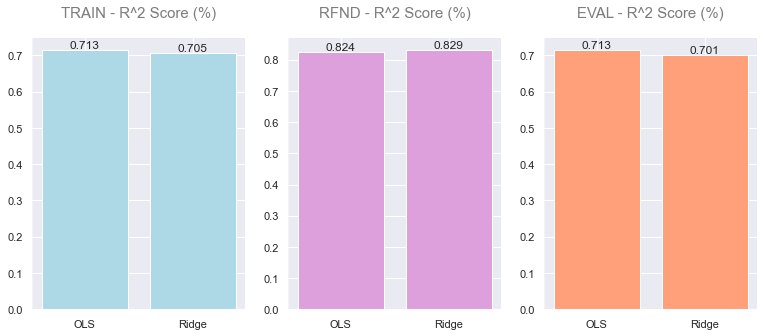


MAE Scores for TRAIN, REFINEMENT & EVALUATION:


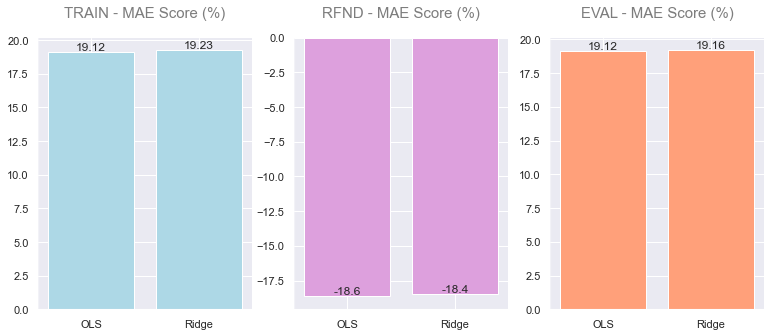

In [50]:
print('R^2 Scores for TRAIN, REFINEMENT & EVALUATION:')
scores_list  = [scores_r2s_trng_selected, scores_r2s_rfnd, scores_r2s_eval]
scores_names = ['TRAIN - R^2 Score (%)', 'RFND - R^2 Score (%)', 'EVAL - R^2 Score (%)']
colors       = ['lightblue', 'plum', 'lightsalmon']

plot_performance_metrics(scores_list, scores_names, colors, modelnms)

print('\nMAE Scores for TRAIN, REFINEMENT & EVALUATION:')
scores_list  = [scores_mae_trng_selected, scores_mae_rfnd, scores_mae_eval]
scores_names = ['TRAIN - MAE Score (%)', 'RFND - MAE Score (%)', 'EVAL - MAE Score (%)']
colors       = ['lightblue', 'plum', 'lightsalmon']

plot_performance_metrics(scores_list, scores_names, colors, modelnms)

The scores generated at various stages suggest that the **`Ordinary Least Squares`** *is the clear winner*. OLS is the best model and it is selected as the final model. OLS will be trained on the entire dataset, saved, and deployed into the test infrastructure for business user's testing (i.e., Model Validation).

In [51]:
# Train the final model on the entire dataset and save it to the disk
FinalModel = LinearRegression(fit_intercept=ols_fit_intercept, normalize=ols_normalize).fit(X, y)
ModelName  = 'MLPy-DemoProj-5.sav'
pickle.dump(FinalModel, open(ModelName, 'wb'))

# 10. Model Validation

In [52]:
# Load the model from the disk and Use it on the real/ unseen data
uat_data_filename = 'data/Bengaluru_House_Data_uat.xlsx'
uat_val_filename  = 'data/Bengaluru_House_Data_uat_val.xlsx'
unseen_house      = read_excel(uat_data_filename, header=None)
unseen_house_val  = read_excel(uat_val_filename, header=None)
unseen_house.rename(columns={0:'location', 1:'total_sqft', 2:'bhk', 3:'bath'}, inplace=True)

predicted_house_prices = []
location               = []
total_sqft             = []
bhk                    = []
bath                   = []

FinalModel_loaded = pickle.load(open(ModelName, 'rb'))

for i in range(len(unseen_house)):
    location.append(unseen_house.loc[i][0])
    total_sqft.append(unseen_house.loc[i][1])
    bhk.append(unseen_house.loc[i][2])
    bath.append(unseen_house.loc[i][3])
    predicted_house_prices.append(predict_house_price(FinalModel_loaded, location[i], total_sqft[i], bhk[i], bath[i]))

In [53]:
print('THE PREDICTED HOUSE PRICES ARE:\n')
print('Location               Total Sqft   BHK   Bath   Predicted Price')
print('--------------------   ----------   ---   ----   ---------------')
for i in range(len(unseen_house)):
     print('%20s   %10.0f   %3.0f   %4.0f   %15.2f' % (location[i], total_sqft[i], bhk[i], bath[i], predicted_house_prices[i]))

THE PREDICTED HOUSE PRICES ARE:

Location               Total Sqft   BHK   Bath   Predicted Price
--------------------   ----------   ---   ----   ---------------
          whitefield         1675     3      3             97.84
          whitefield         1400     2      3             83.30
          whitefield         1200     2      2             62.08
            Balagere         1100     2      2             68.95
            Balagere          655     1      1             35.54
         BEML Layout         1340     2      2             93.85
         BEML Layout         2000     3      3            144.07
              Domlur         1900     3      3            155.85
              Domlur         1200     2      2            102.50
     Electronic City          620     1      1             12.87
     Electronic City         1100     2      2             49.02
     Electronic City         1370     3      2             63.17
     Electronic City         1500     3      3           

# 11. Model Deployment

The model deployment is usually done by the DS team along with the ML team upon receipt of stakeholders sign-off.